This notebook produces the plots for the main text of the photon noise paper.

In [1]:
save_pdf = True
save_eps = True

In [17]:
import os
import pandas as pd
from scipy.constants import h, k as k_B, pi
import matplotlib as mpl
print(mpl.matplotlib_fname())
#from kid_readout.analysis import archive, dataframe, plot_dataframe
plt.rcParams['font.size'] = 11

/home/flanigan/notebooks/paper/2016_Flanigan_APL/15/matplotlibrc


# Load data

In [3]:
cw = pd.DataFrame(np.load('continuous-wave.npy'))
bb = pd.DataFrame(np.load('broadband.npy'))

# Select data

cw_file_max = 'cw20_ampfreebincut10prop'
cw_file_short = 'afbc10p'
bb_file_max = 'bb20_ampfreebincut10prop'
bb_file_short = 'afbc10p'

In [4]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_short = 'afbc10p'

In [5]:
cw_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(cw_max_short)
bb_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(bb_max_short)

# Functions

In [6]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()


def histogram(ax, bins, values, **kwargs):
    x = np.zeros(2 * bins.size)
    y = np.zeros(x.size)
    x[0::2] = x[1::2] = bins
    y[1:-2:2] = y[2:-1:2] = values
    ax.plot(x, y, **kwargs)
    return x, y


def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
    else:
        unit = 'pW'
        scale = 1
    scaled = 1e12 * scale * f
    precision = 2 - int(np.floor(np.log10(scaled)))
    format_string = '{{:.{}f}} {{}}'.format(precision)
    return format_string.format(scaled, unit)


def white_noise_model(f, series):
    W2 = series.noise_fit_device_noise
    A2 = series.noise_fit_amplifier_noise
    f_c = series.noise_fit_fc
    return W2 / (1 + (f / f_c)**2) + A2


def pink_noise_model(f, series, key):
    W2 = series['{}_white'.format(key)]
    A2 = series['{}_amp'.format(key)]
    f_c = series['{}_invtau'.format(key)]
    f_k = series['{}_fknee'.format(key)]
    alpha = series['{}_alpha'.format(key)]
    return W2 * (1 + (f / f_k)**(-alpha)) / (1 + (f / f_c)**2) + A2

In [7]:
eta_bb = common(bb, 'eta')
B_bb = common(bb, 'B')

eta_cw = common(cw, 'eta')

single_channel = common(bb, 'channel')
#atten = 29
nu_cw = common(cw, 'timestream_mmw_source_freq')
nu_bb = 150e9

In [8]:
noise_colormap = plt.cm.RdYlBu_r
cw_color = 'saddlebrown' #'darkgoldenrod'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"
bb_label = "broadband"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 1e-19, Sx_scale * 3e-15)
noise_xlimits = (1e1, 1e4)

PA_scale = 1e12
X_scale = 1e6
PA_limits = (8e-4, 6e1)
X_limits = (1e-1, 1e3)
NEPA_limits = (1e-18, 1e-15)
PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
to_aWrtHz = 1e18

In [9]:
mappable_cw = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(cw.source_power), max(cw.source_power)),
                                    cmap=noise_colormap)
mappable_cw.set_array(cw.source_power)

mappable_bb = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(bb.source_power), max(bb.source_power)),
                                    cmap=noise_colormap)
mappable_bb.set_array(bb.source_power)

# Results

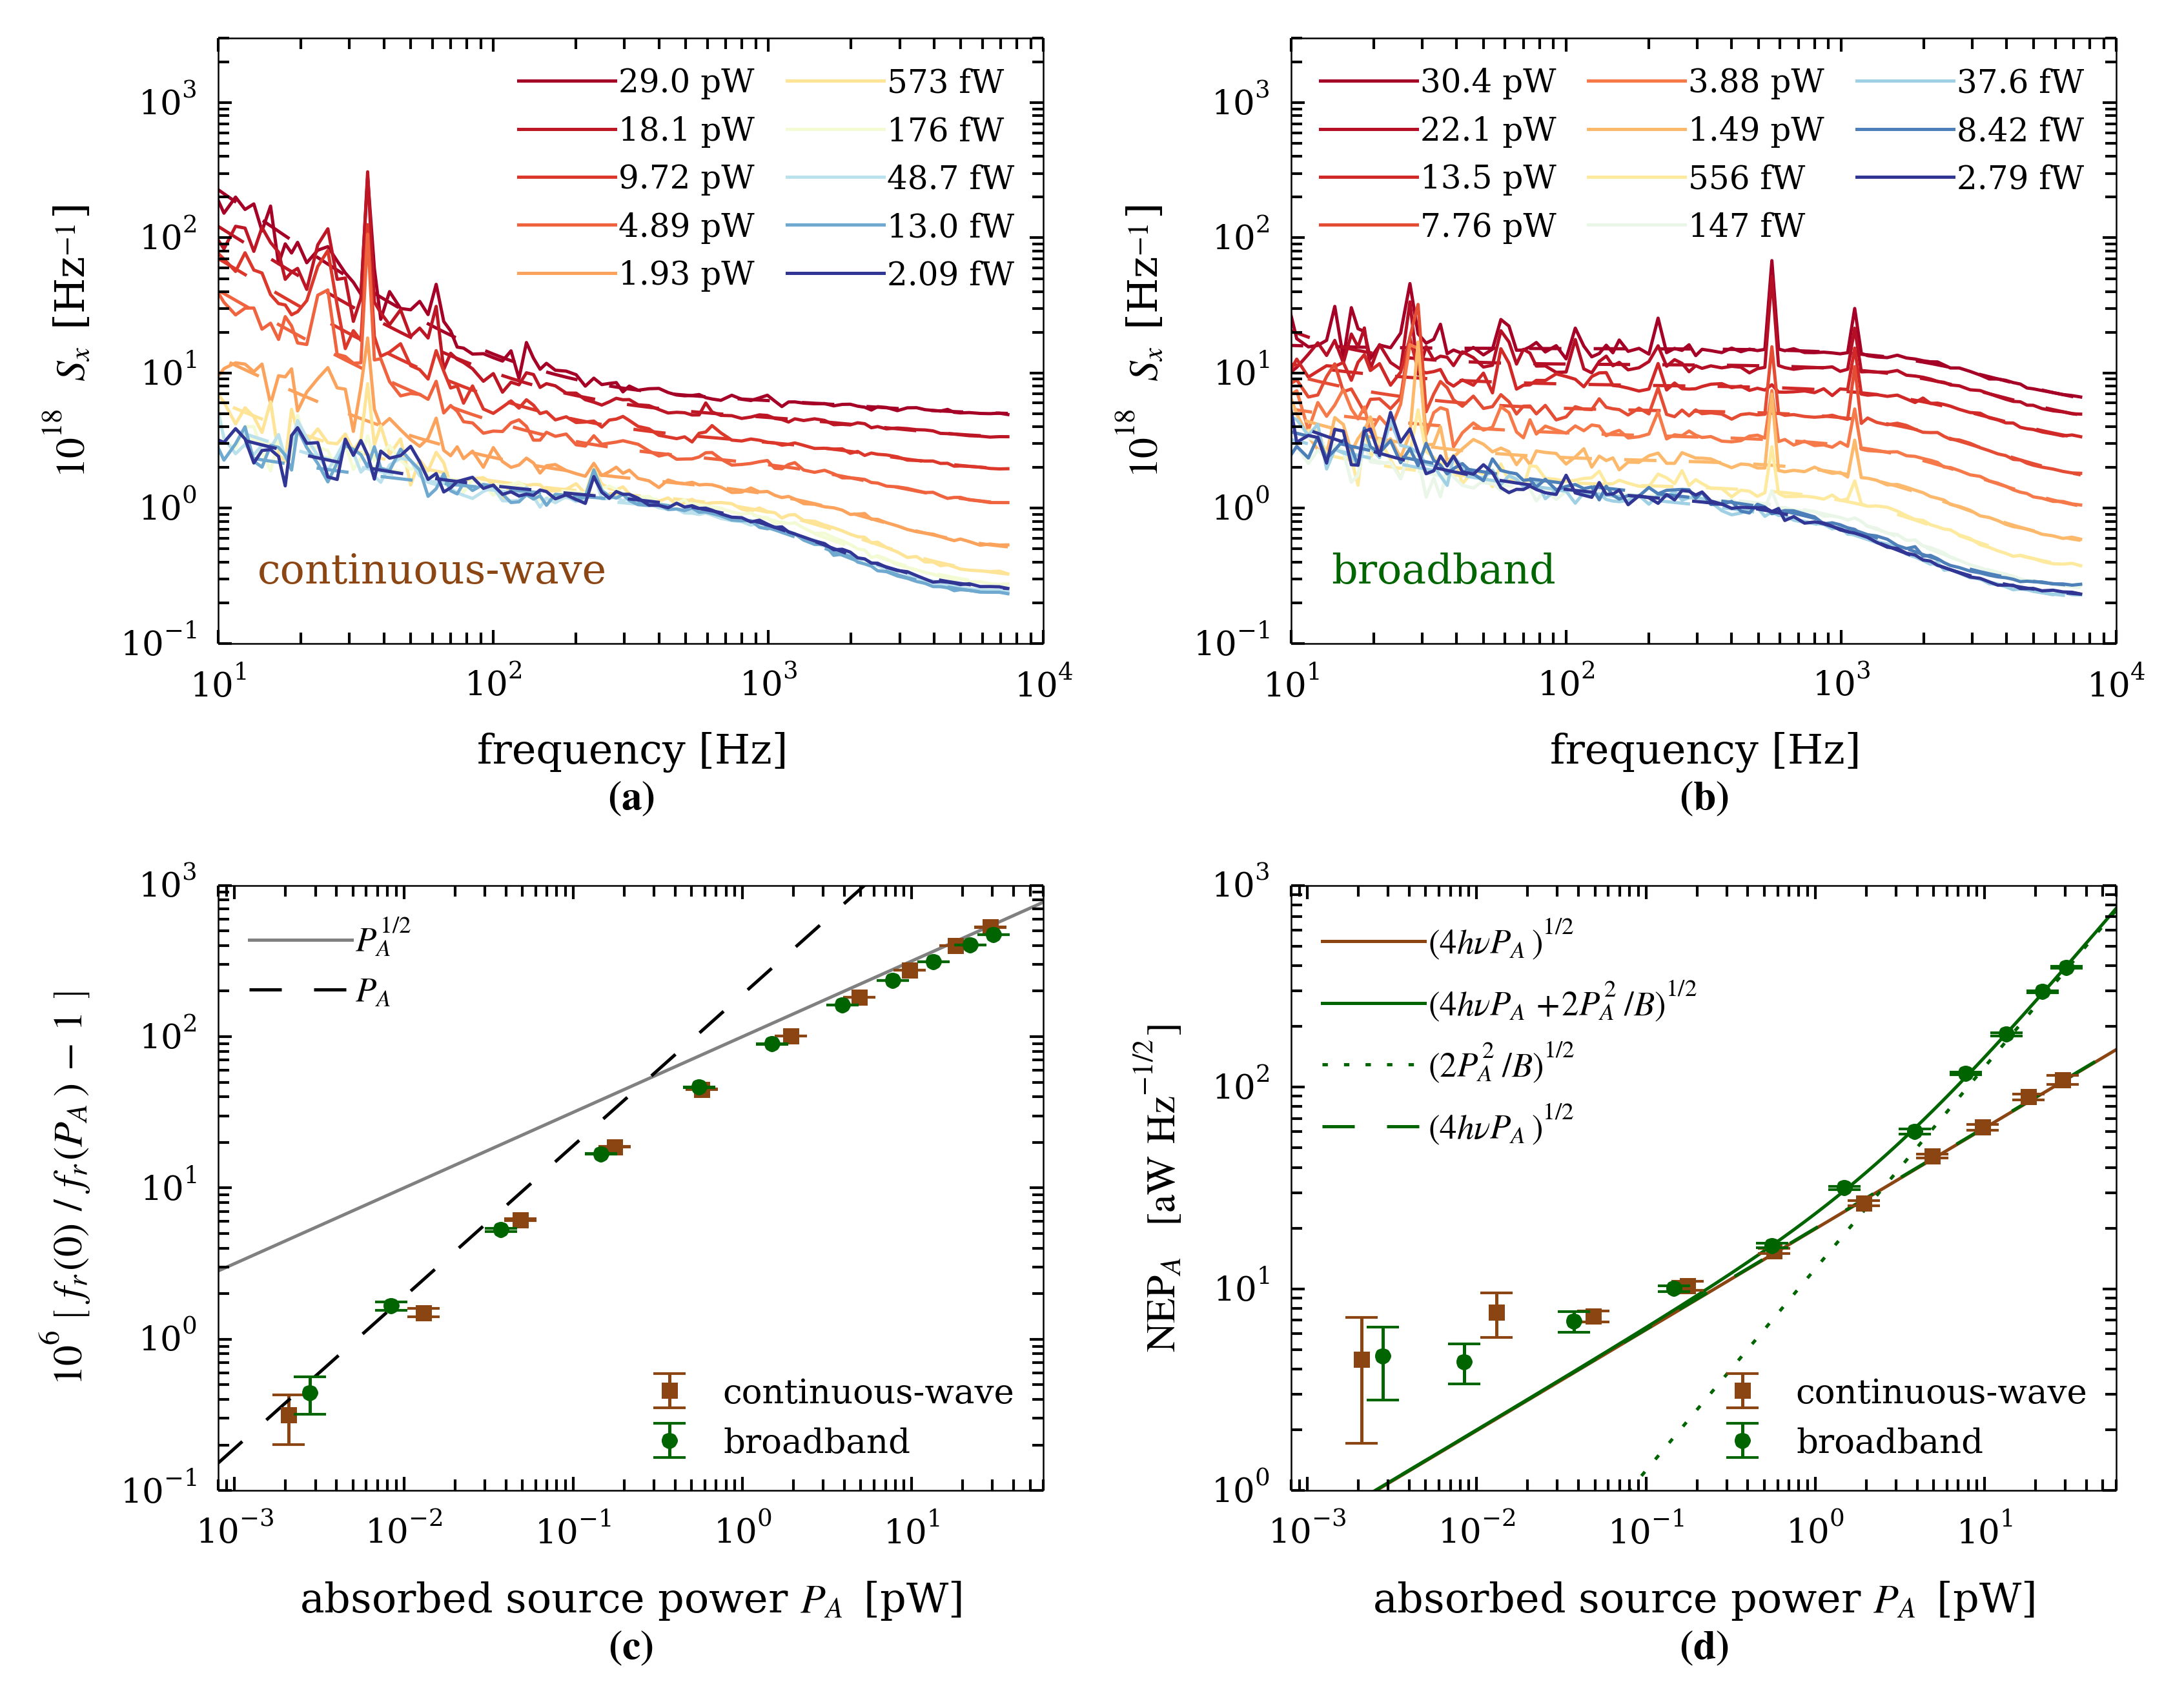

In [10]:
with plt.rc_context({'figure.subplot.wspace': 0.3,
                     'figure.subplot.hspace': 0.4,
#                     'lines.linewidth': 0.8,
                     'legend.fontsize': 'xx-small',
                     }):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))
    (cw_ax, bb_ax, response_ax, nep_ax) = axes.flatten()
    
    for index, row in cw.iterrows():
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_cw.to_rgba(row.source_power), alpha=1,
                     label=float_to_latex(eta_cw * row.source_power))
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * pink_noise_model(row.pca_freq, row, cw_max_name),
                     '--', color=mappable_cw.to_rgba(row.source_power))
    cw_ax.set_xlabel("frequency [Hz]\n" + r"${\bf(a)}$")
    cw_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    cw_ax.set_xlim(*noise_xlimits)
    cw_ax.set_ylim(*noise_ylimits)
    cw_ax.legend(loc='upper right', ncol=2, fontsize=6)
    cw_ax.text(0.05, 0.1, cw_label, size='x-small', color=cw_color, transform=cw_ax.transAxes)

    # Broadband
    for index, row in bb.iterrows():
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_bb.to_rgba(row.source_power), alpha=1,
                     label=float_to_latex(eta_bb * row.source_power))
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * pink_noise_model(row.pca_freq, row, bb_max_name),
                     '--', color=mappable_bb.to_rgba(row.source_power))
    bb_ax.set_xlabel("frequency [Hz]\n" + r"${\bf(b)}$")
    bb_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    bb_ax.set_xlim(*noise_xlimits)
    bb_ax.set_ylim(*noise_ylimits)
    bb_ax.legend(loc='upper left', ncol=3, fontsize=6)
    bb_ax.text(0.05, 0.1, bb_label, size='x-small', color=bb_color, transform=bb_ax.transAxes)

    # Response
    response_ax.plot(PA_scale * PA_line,
                     1.0e2 * (PA_scale * PA_line)**(1/2),
                     '-', color='gray', label='$P_A^{1/2}$')
    response_ax.plot(PA_scale * PA_line,
                     1.9e2 * (PA_scale * PA_line)**1,
                     '--', color='black', label='$P_A$')

    for df, eta, color, marker, label in zip((cw, bb), (eta_cw, eta_bb),
                                             (cw_color, bb_color), (cw_marker, bb_marker),
                                             (cw_label, bb_label)):
        response_ax.errorbar(PA_scale * eta * df.source_power,
                             X_scale * df.source_power_X,
                             yerr=X_scale * df.source_power_X_err,
                             marker=marker, color=color, label=label,
                             linestyle='none', markeredgecolor='none')

    response_ax.set_xlim(*PA_limits)
    response_ax.set_ylim(*X_limits)
    response_ax.set_xscale('log')
    response_ax.set_yscale('log', nonposy='clip')
    response_ax.set_ylabel(r'$10^6 \left[ \, f_r(0) \, / \, f_r(P_A) \, - \, 1 \, \right]$')
    response_ax.set_xlabel("absorbed source power $P_A$ [pW]\n"  + r"${\bf(c)}$")
    response_handles, response_labels = response_ax.get_legend_handles_labels()
    response_ax.add_artist(response_ax.legend(response_handles[:2], response_labels[:2], loc='upper left'))
    response_ax.legend(response_handles[2:], response_labels[2:], loc='lower right')

    # NEP
    NEP_cw = eta_cw * cw[cw_NEP2_key]**(1/2)
    NEP_cw_err = NEP_cw * (1/2) * (cw[cw_NEP2_key + '_err'] / cw[cw_NEP2_key])
    NEP_bb = eta_bb * bb[bb_NEP2_key]**(1/2)
    NEP_bb_err = NEP_bb * (1/2) * (bb[bb_NEP2_key + '_err'] / bb[bb_NEP2_key])

    # 0
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_cw * PA_line)**(1/2),
                '-', color=cw_color, label=r'$(4 h \nu P_A)^{1/2}$')
    # 1
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_bb * PA_line)**(1/2),
                '--', color=bb_color, label=r'$(4 h \nu P_A)^{1/2}$')
    # 2
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (2 * PA_line**2 / B_bb)**(1/2),
                ':', color=bb_color, label=r'$(2 P_A^2 / B)^{1/2}$')
    # 3
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_bb * PA_line + 2 * PA_line**2 / B_bb)**(1/2),
                '-', color=bb_color, label=r'$(4 h \nu P_A + 2 P_A^2 / B)^{1/2}$')
    
    nep_ax.errorbar(PA_scale * eta_cw * cw.source_power,
                    to_aWrtHz * NEP_cw,
                    yerr=to_aWrtHz * NEP_cw_err,
                    marker=cw_marker, markeredgecolor='none', linestyle='none',
                    color=cw_color, label=cw_label)

    nep_ax.errorbar(PA_scale * eta_bb * bb.source_power,
                    to_aWrtHz * NEP_bb,
                    yerr=to_aWrtHz * NEP_bb_err,
                    marker=bb_marker, markeredgecolor='none', linestyle='none',
                    color=bb_color, label=bb_label)

    nep_ax.set_xlabel('absorbed source power $P_A$ [pW]\n' + r'${\bf(d)}$')
    nep_ax.set_ylabel(r'$\mathrm{NEP}_A \; [\mathrm{aW} \, \mathrm{Hz}^{-1/2}]$')
    nep_ax.set_xlim(*PA_limits)
    nep_ax.set_ylim(to_aWrtHz * NEPA_limits[0], to_aWrtHz * NEPA_limits[1]);
    nep_ax.set_yscale('log', nonposy='clip')
    nep_ax.set_xscale('log')
    nep_handles, nep_labels = nep_ax.get_legend_handles_labels()
    order = [0, 3, 2, 1]
    nep_ax.add_artist(nep_ax.legend([nep_handles[n] for n in order],
                                    [nep_labels[n] for n in order], loc='upper left'))
    nep_ax.legend(nep_handles[4:6], nep_labels[4:6], loc='lower right')

if save_pdf:
    fig.savefig('results.pdf', pad_inches=0.01)
if save_eps:
    fig.savefig('results.eps', pad_inches=0.01)

# Support

This section contains plots and calculations that support values quoted in the text.

In [11]:
print("Continuous-wave: {:.3f} MHz".format(cw.f_r.max()))
print("Broadband: {:.3f} MHz".format(bb.f_r.max()))

Continuous-wave: 164.088 MHz
Broadband: 164.088 MHz


In [12]:
cw[['mmw_atten_total_turns', 'atten', 'power_dbm']]

,mmw_atten_total_turns,atten,power_dbm
0,8,29,-100.0412
1,9,29,-100.0412
2,10,29,-100.0412
3,11,29,-100.0412
4,12,29,-100.0412
5,13,29,-100.0412
6,14,29,-100.0412
7,15,29,-100.0412
8,16,29,-100.0412
9,17,29,-100.0412


In [13]:
bb[['mmw_atten_total_turns', 'atten', 'power_dbm']]

,mmw_atten_total_turns,atten,power_dbm
0,6,29,-100.0412
1,7,29,-100.0412
2,8,29,-100.0412
3,9,29,-100.0412
4,10,29,-100.0412
5,11,29,-100.0412
6,12,29,-100.0412
7,13,29,-100.0412
8,14,29,-100.0412
9,15,29,-100.0412


The effect of the source power appears to saturate below approximately

In [14]:
P_sat = 0.01e-12

The corresponding generation rate is

In [15]:
Gamma_sat = 2 * P_sat / (h * 150e9)
'{:.3g}'.format(Gamma_sat)

'2.01e+08'

This is a repeat of the calculation of the saturation power:

In [22]:
def thermal_occupancy(nu, T):
    return (np.exp(h * nu / (k_B * T)) - 1)**(-1)

T = 2
nu = 150e9
eta_F = 0.94 # Not included in the calculation; presumably wrapped into eta_I.
eta_I = 0.7
B_full = 40e9
P_A = eta_I * thermal_occupancy(nu, T) * h * nu * B_full
1e12 * P_A  # in pW

0.078222232253651491

In [25]:
# The limiting NEP due to the 2 K background:
NEP_A0 = (2 * 2 * h * nu * P_A)**(1/2)
NEP_A0

5.5765901023836741e-18